In [ ]:
import numpy as np
import cv2
import glob
import os
# 1. CHECKERBOARD DIMENSIONS (internal corners: width-1, height-1)
#    For an 8x8 squares board, this is (7, 7)
CHECKERBOARD_DIMS = (7, 7) 

# 2. SQUARE SIZE (in any real-world unit, e.g., mm, cm, inches)
#    Measure one square on your physical checkerboard (on your laptop screen).
SQUARE_SIZE_MM = 21  # <--- IMPORTANT: MEASURE THIS ACCURATELY ON YOUR SCREEN!

# 3. IMAGE FILE PATHS (use wildcards)
#    Update these to match your folder structure. Assuming .jpg files.
IMAGES_PATH_LEFT = 'calibration/'
IMAGES_PATH_RIGHT = 'calibration/'

# Termination criteria for corner refinement (used in cornerSubPix and stereoCalibrate)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Prepare 3D object points (e.g., (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0) scaled by SQUARE_SIZE_MM)
objp = np.zeros((CHECKERBOARD_DIMS[0] * CHECKERBOARD_DIMS[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:CHECKERBOARD_DIMS[0], 0:CHECKERBOARD_DIMS[1]].T.reshape(-1, 2)
objp = objp * SQUARE_SIZE_MM # Scale by square size

# Arrays to store object points and image points from all images
objpoints = []  # 3D points in real world space (the checkerboard corners)
imgpoints_left = [] # 2D points in left image plane (detected pixel coordinates)
imgpoints_right = [] # 2D points in right image plane (detected pixel coordinates)

# Get image file names
images_left = sorted(glob.glob(IMAGES_PATH_LEFT))
images_right = sorted(glob.glob(IMAGES_PATH_RIGHT))

# --- Initial checks for image loading ---
if not images_left or not images_right:
    print("Error: No images found. Check your IMAGE_PATH settings and folder structure.")
    print(f"Looked for: '{IMAGES_PATH_LEFT}' and '{IMAGES_PATH_RIGHT}'")
    exit()

print(f"Found {len(images_left)} left images and {len(images_right)} right images.")

# Ensure we have a matching number of images
if len(images_left) != len(images_right):
    print("Error: Mismatched number of left and right images. Aborting.")
    exit()

# Store image dimensions (will be taken from the first image loaded)
image_size = None 

# Flags for findChessboardCorners (helps with lighting and image normalization)
find_corner_flags = cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_NORMALIZE_IMAGE + cv2.CALIB_CB_FAST_CHECK

# Iterate through all image pairs
for img_left_path, img_right_path in zip(images_left, images_right):
    img_left = cv2.imread(img_left_path)
    img_right = cv2.imread(img_right_path)
    
    # Check if images were loaded successfully
    if img_left is None:
        print(f"Warning: Could not load left image: {img_left_path}. Skipping pair.")
        continue
    if img_right is None:
        print(f"Warning: Could not load right image: {img_right_path}. Skipping pair.")
        continue

    gray_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
    gray_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)
    
    # Get image size from the first valid image (assuming all are same size)
    if image_size is None:
        image_size = gray_left.shape[::-1] # (width, height)

    # Find the chess board corners
    ret_left, corners_left = cv2.findChessboardCorners(gray_left, CHECKERBOARD_DIMS, find_corner_flags)
    ret_right, corners_right = cv2.findChessboardCorners(gray_right, CHECKERBOARD_DIMS, find_corner_flags)

    # --- If corners are found in BOTH images ---
    if ret_left and ret_right:
        print(f"Corners found in pair: {os.path.basename(img_left_path)} / {os.path.basename(img_right_path)}")
        
        # Add the 3D object points
        objpoints.append(objp)

        # Refine 2D corner locations for more accuracy
        corners_left_refined = cv2.cornerSubPix(gray_left, corners_left, (11, 11), (-1, -1), criteria)
        imgpoints_left.append(corners_left_refined)
        
        corners_right_refined = cv2.cornerSubPix(gray_right, corners_right, (11, 11), (-1, -1), criteria)
        imgpoints_right.append(corners_right_refined)

        # (Optional) Draw and display corners to verify. Uncomment these lines if you want to see them.
        # cv2.drawChessboardCorners(img_left, CHECKERBOARD_DIMS, corners_left_refined, ret_left)
        # cv2.imshow('Left Image', cv2.resize(img_left, (640, 480)))
        # cv2.drawChessboardCorners(img_right, CHECKERBOARD_DIMS, corners_right_refined, ret_right)
        # cv2.imshow('Right Image', cv2.resize(img_right, (640, 480)))
        # cv2.waitKey(500) # Wait 500ms between displaying images

    else:
        print(f"Corners NOT found in pair: {os.path.basename(img_left_path)} / {os.path.basename(img_right_path)}")

cv2.destroyAllWindows() # Close any OpenCV display windows

if not objpoints:
    print("\nError: No valid corner pairs were found in any images.")
    print("Calibration cannot proceed. Check CHECKERBOARD_DIMS, SQUARE_SIZE_MM, image quality, lighting, or borders.")
    exit()

if image_size is None: # Additional safety check
    print("\nError: No images were successfully loaded to determine image size. Calibration aborted.")
    exit()

print(f"\nCalibrating with {len(objpoints)} valid image pairs (image size: {image_size[0]}x{image_size[1]})...")

# --------------------
# 3. PERFORM STEREO CALIBRATION
# --------------------
# K_left, D_left: Left camera intrinsic matrix and distortion coefficients
# K_right, D_right: Right camera intrinsic matrix and distortion coefficients
# R, T: Rotation and Translation matrices between the two cameras
# E, F: Essential and Fundamental matrices
ret, K_left, D_left, K_right, D_right, R, T, E, F = cv2.stereoCalibrate(
    objpoints, 
    imgpoints_left, 
    imgpoints_right,
    None, None, # cameraMatrix1, distCoeffs1 (will be calculated)
    None, None, # cameraMatrix2, distCoeffs2 (will be calculated)
    imageSize=image_size, 
    criteria=criteria, 
    flags=cv2.CALIB_SAME_FOCAL_LENGTH # Best flag for two identical phone cameras, assumes focal length is same
)

if ret:
    print("Calibration successful!")
    
    # --------------------
    # 4. SAVE RESULTS
    # --------------------
    output_file = 'stereo_calibration.npz'
    np.savez(output_file, 
             K_left=K_left, D_left=D_left,
             K_right=K_right, D_right=D_right,
             R=R, T=T, E=E, F=F, imageSize=np.array(image_size))
    
    print(f"\nCalibration data saved to '{output_file}'")
    print("\n--- Key Matrices ---")
    print(f"K_left (Left Intrinsics):\n{K_left}")
    print(f"\nD_left (Left Distortion):\n{D_left}")
    print(f"\nK_right (Right Intrinsics):\n{K_right}")
    print(f"\nD_right (Right Distortion):\n{D_right}")
    print(f"\nR (Rotation between cameras):\n{R}")
    print(f"\nT (Translation vector - your 'baseline' in mm):\n{T}") # T is in the same units as SQUARE_SIZE_MM
    print(f"\nE (Essential Matrix):\n{E}")
    print(f"\nF (Fundamental Matrix):\n{F}")
    
else:
    print("Calibration failed.")
    print("Reasons might include: too few valid corner pairs, poor image quality, or incorrect checkerboard dimensions.")

Found 1 left images and 1 right images.

Error: No valid corner pairs were found in any images.
Calibration cannot proceed. Check CHECKERBOARD_DIMS, SQUARE_SIZE_MM, image quality, lighting, or borders.

Error: No images were successfully loaded to determine image size. Calibration aborted.


TypeError: 'NoneType' object is not subscriptable

: 

### Step 2: Image Rectification

--- Step 2: Image Rectification ---
Calibration data loaded from stereo_calibration.npz
Image Size from calibration: 756x1008

Stereo Rectification parameters computed:
R1 (Left Rectification Rotation):
[[ 0.99732266  0.07034336  0.01998297]
 [-0.07026923  0.99751841 -0.00438891]
 [-0.02024211  0.00297297  0.99979069]]
P1 (Left Rectification Projection):
[[920.65015908   0.         451.20952535   0.        ]
 [  0.         920.65015908 336.5151515    0.        ]
 [  0.           0.           1.           0.        ]]
R2 (Right Rectification Rotation):
[[ 0.99642688 -0.08229295  0.01900886]
 [ 0.08222231  0.99660399  0.00446957]
 [-0.01931212 -0.00289065  0.99980932]]
P2 (Right Rectification Projection):
[[ 9.20650159e+02  0.00000000e+00  4.51209525e+02 -1.85122373e+05]
 [ 0.00000000e+00  9.20650159e+02  3.36515152e+02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]]
Q (Reprojection Matrix - crucial for 3D):
[[ 1.00000000e+00  0.00000000e+00  0.000000

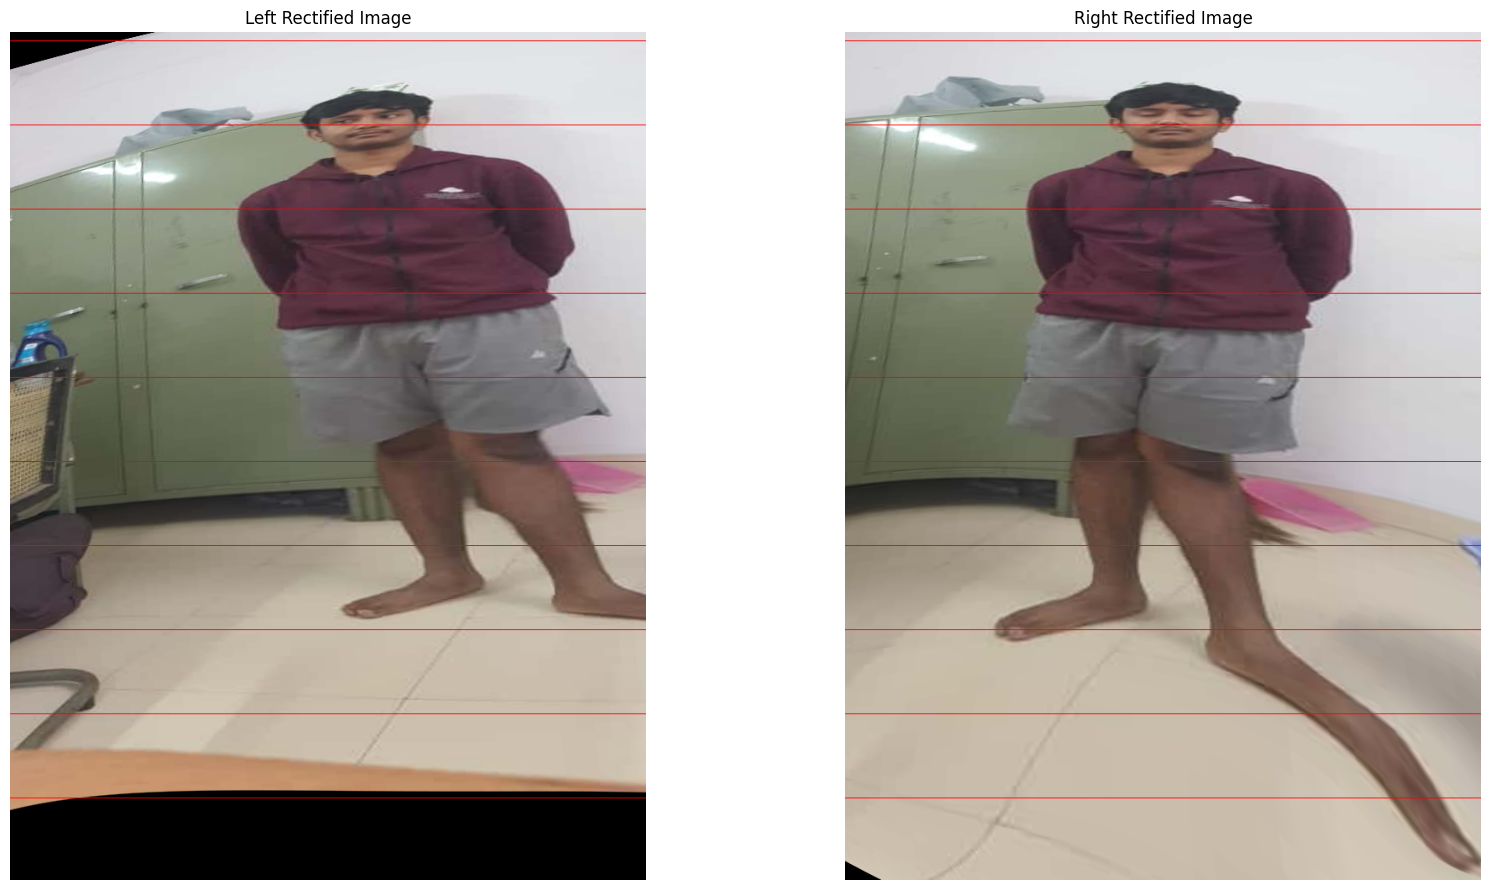


Rectification complete. Verify that corresponding features align horizontally.
The matrices R1, P1, R2, P2, and especially Q, are now saved in your script's memory.
You will need to save the Q matrix for Step 3.


In [ ]:
import numpy as np

import matplotlib.pyplot as plt # For notebook visualization

# ===================================================================
# -------------------- CONFIGURATION (EDIT THIS) --------------------
# ===================================================================

# Path to your saved calibration file from Step 1
CALIBRATION_FILE = 'stereo_calibration.npz'

# Path to ONE example stereo image pair you want to rectify
# Use images that are *NOT* from your calibration set, if possible.
# Make sure these paths match your folder structure (e.g., 'images/left/test_01.jpg')
EXAMPLE_LEFT_IMAGE = 'images/left/test_01.jpg' 
EXAMPLE_RIGHT_IMAGE = 'images/right/test_01.jpg'

# Output directory for rectified images (will be created if it doesn't exist)
OUTPUT_DIR = 'rectified_images'

# ===================================================================
# -------------------- END OF CONFIGURATION -------------------------
# ===================================================================

print("--- Step 2: Image Rectification ---")

# --- 1. Load Calibration Data ---
try:
    with np.load(CALIBRATION_FILE) as data:
        K_left = data['K_left']
        D_left = data['D_left']
        K_right = data['K_right']
        D_right = data['D_right']
        R = data['R']
        T = data['T']
        image_size = tuple(data['imageSize'])
    print(f"Calibration data loaded from {CALIBRATION_FILE}")
    print(f"Image Size from calibration: {image_size[0]}x{image_size[1]}")
except FileNotFoundError:
    print(f"Error: Calibration file '{CALIBRATION_FILE}' not found. Please run Step 1 calibration first.")
    exit()
except Exception as e:
    print(f"Error loading calibration data: {e}")
    exit()

# --- 2. Compute Rectification Maps ---
# R1, R2, P1, P2: rectification transforms (rotation and projection matrices)
# Q: reprojection matrix (for 3D reconstruction)
R1, R2, P1, P2, Q, _, _ = cv2.stereoRectify(
    K_left, D_left, K_right, D_right, image_size, R, T,
    alpha=-1 # -1 means crop all black pixels, 0 means keep all pixels (adds black borders)
)

print("\nStereo Rectification parameters computed:")
print(f"R1 (Left Rectification Rotation):\n{R1}")
print(f"P1 (Left Rectification Projection):\n{P1}")
print(f"R2 (Right Rectification Rotation):\n{R2}")
print(f"P2 (Right Rectification Projection):\n{P2}")
print(f"Q (Reprojection Matrix - crucial for 3D):\n{Q}")


# --- 3. Create Remapping Functions ---
# map1x, map1y: maps for the left image
# map2x, map2y: maps for the right image
map1x, map1y = cv2.initUndistortRectifyMap(K_left, D_left, R1, P1, image_size, cv2.CV_32FC1)
map2x, map2y = cv2.initUndistortRectifyMap(K_right, D_right, R2, P2, image_size, cv2.CV_32FC1)

print("\nUndistortRectifyMap computed. Ready for remapping.")

# --- 4. Rectify an Example Image Pair ---
print(f"\nRectifying example images: {EXAMPLE_LEFT_IMAGE} and {EXAMPLE_RIGHT_IMAGE}")
try:
    img_left_orig = cv2.imread(EXAMPLE_LEFT_IMAGE)
    img_right_orig = cv2.imread(EXAMPLE_RIGHT_IMAGE)

    if img_left_orig is None or img_right_orig is None:
        raise FileNotFoundError("Could not load example images. Check paths.")
        
    # Perform the actual remapping (rectification)
    img_left_rectified = cv2.remap(img_left_orig, map1x, map1y, cv2.INTER_LINEAR)
    img_right_rectified = cv2.remap(img_right_orig, map2x, map2y, cv2.INTER_LINEAR)
    
    # Save rectified images
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    cv2.imwrite(os.path.join(OUTPUT_DIR, 'left_rectified.jpg'), img_left_rectified)
    cv2.imwrite(os.path.join(OUTPUT_DIR, 'right_rectified.jpg'), img_right_rectified)
    print(f"Rectified images saved to '{OUTPUT_DIR}'.")

except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please update EXAMPLE_LEFT_IMAGE and EXAMPLE_RIGHT_IMAGE in the CONFIG section.")
    exit()
except Exception as e:
    print(f"Error during rectification of example images: {e}")
    exit()

# --- 5. Visualize Rectification (Crucial) ---
print("\nDisplaying rectified images for verification (horizontal alignment check)...")

# Convert BGR to RGB for matplotlib
img_left_rectified_rgb = cv2.cvtColor(img_left_rectified, cv2.COLOR_BGR2RGB)
img_right_rectified_rgb = cv2.cvtColor(img_right_rectified, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2, figsize=(18, 9))
axes[0].imshow(img_left_rectified_rgb)
axes[0].set_title('Left Rectified Image')
axes[0].axis('off')
axes[1].imshow(img_right_rectified_rgb)
axes[1].set_title('Right Rectified Image')
axes[1].axis('off')

# Draw horizontal lines to verify alignment
# Draw a few lines to check alignment across the image
for i in range(10, image_size[1] - 10, image_size[1] // 10): # from y=10 to height-10, step by 1/10 of height
    cv2.line(img_left_rectified_rgb, (0, i), (image_size[0], i), (255, 0, 0), 1) # Red line
    cv2.line(img_right_rectified_rgb, (0, i), (image_size[0], i), (255, 0, 0), 1) # Red line

# Re-display with lines (optional, if you want lines only on the plot)
axes[0].imshow(img_left_rectified_rgb)
axes[1].imshow(img_right_rectified_rgb)

plt.tight_layout()
plt.show()

print("\nRectification complete. Verify that corresponding features align horizontally.")
print("The matrices R1, P1, R2, P2, and especially Q, are now saved in your script's memory.")
print("You will need to save the Q matrix for Step 3.")

### 🚀 Step 3: Dense Disparity Map Generation

--- Step 3: Dense Disparity Map Generation ---
Rectified images loaded from 'rectified_images'.

Initializing Stereo SGBM Matcher...
Computing disparity map (this may take a moment)...
Normalizing and displaying disparity map...
Visualized disparity map saved to 'disparity_maps'.


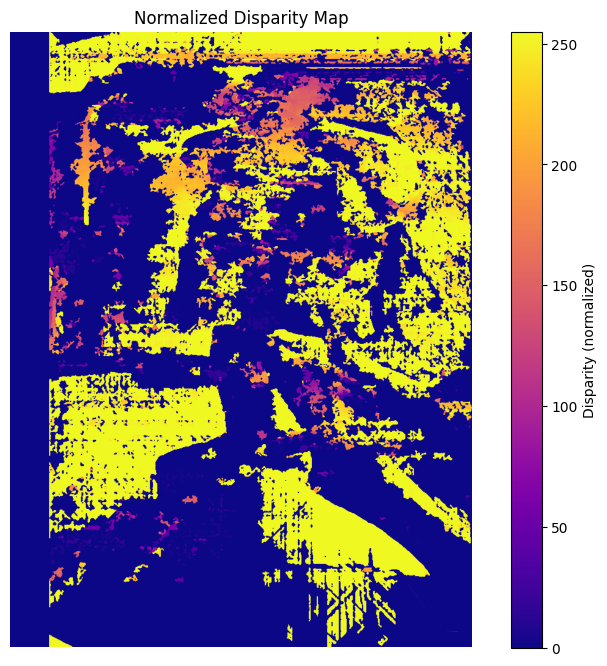


Disparity map generation complete.
The 'raw_disparity' variable holds the floating-point disparity values (not normalized).
You will need this 'raw_disparity' and the 'Q' matrix (from Step 2) for Step 4 (Depth Map).


In [ ]:


# ===================================================================
# -------------------- CONFIGURATION (EDIT THIS) --------------------
# ===================================================================

# Input directory for rectified images from Step 2
RECTIFIED_IMAGES_DIR = 'rectified_images'
LEFT_RECTIFIED_IMAGE = os.path.join(RECTIFIED_IMAGES_DIR, 'left_rectified.jpg')
RIGHT_RECTIFIED_IMAGE = os.path.join(RECTIFIED_IMAGES_DIR, 'right_rectified.jpg')

# Output directory for the disparity map (will be created if it doesn't exist)
OUTPUT_DIR_DISPARITY = 'disparity_maps'

# SGBM Parameters (these are starting points, you'll likely tune these!)
# See explanations below for each parameter.
SGBM_NUM_DISPARITIES = 64  # Must be divisible by 16. Controls the range of depth. Higher = more range, slower.
SGBM_BLOCK_SIZE = 3      # Must be odd, between 3 and 11. Size of the block for matching. Smaller = finer detail, more noise.
SGBM_MIN_DISPARITY = 0     # Minimum disparity value (usually 0).

# P1 and P2 control penalty for disparity changes. Higher = smoother disparity map.
# P1 = 8 * channel_count * SGBM_BLOCK_SIZE^2
# P2 = 32 * channel_count * SGBM_BLOCK_SIZE^2
# For grayscale, channel_count is 1.
SGBM_P1 = 8 * 1 * SGBM_BLOCK_SIZE**2
SGBM_P2 = 32 * 1 * SGBM_BLOCK_SIZE**2

SGBM_DISP12_MAX_DIFF = 1   # Maximum allowed difference in the left-right disparity check. Adjust for noise/holes.
SGBM_UNIQUENESS_RATIO = 10 # Percentage. If a match is not unique enough, it's discarded.
SGBM_SPECKLE_WINDOW_SIZE = 100 # Discard regions smaller than this. Helps remove speckles/noise.
SGBM_SPECKLE_RANGE = 32    # Disparity variation within a speckle window.
SGBM_PREFILTER_CAP = 63    # Truncates pre-filtered image values (improves matching of textureless areas).

# ===================================================================
# -------------------- END OF CONFIGURATION -------------------------
# ===================================================================

print("--- Step 3: Dense Disparity Map Generation ---")

# --- 1. Load Rectified Images ---
try:
    img_left_rectified = cv2.imread(LEFT_RECTIFIED_IMAGE)
    img_right_rectified = cv2.imread(RIGHT_RECTIFIED_IMAGE)

    if img_left_rectified is None or img_right_rectified is None:
        raise FileNotFoundError("Could not load rectified images. Check paths.")
        
    # Convert to grayscale for disparity calculation
    gray_left = cv2.cvtColor(img_left_rectified, cv2.COLOR_BGR2GRAY)
    gray_right = cv2.cvtColor(img_right_rectified, cv2.COLOR_BGR2GRAY)
    print(f"Rectified images loaded from '{RECTIFIED_IMAGES_DIR}'.")

except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please ensure you have run Step 2 and the rectified images are in the specified directory.")
    exit()
except Exception as e:
    print(f"Error loading images for disparity: {e}")
    exit()

# --- 2. Initialize SGBM Matcher ---
print("\nInitializing Stereo SGBM Matcher...")
stereo = cv2.StereoSGBM_create(
    minDisparity=SGBM_MIN_DISPARITY,
    numDisparities=SGBM_NUM_DISPARITIES,
    blockSize=SGBM_BLOCK_SIZE,
    P1=SGBM_P1,
    P2=SGBM_P2,
    disp12MaxDiff=SGBM_DISP12_MAX_DIFF,
    uniquenessRatio=SGBM_UNIQUENESS_RATIO,
    speckleWindowSize=SGBM_SPECKLE_WINDOW_SIZE,
    speckleRange=SGBM_SPECKLE_RANGE,
    preFilterCap=SGBM_PREFILTER_CAP,
    # fullDP=False # If True, enables a more thorough but slower optimization. Default is False.
)

# --- 3. Compute Disparity ---
print("Computing disparity map (this may take a moment)...")
# disparity map is 16-bit signed fixed-point, multiply by 16 for float values
raw_disparity = stereo.compute(gray_left, gray_right).astype(np.float32) / 16.0

# --- 4. Normalize and Visualize Disparity Map ---
print("Normalizing and displaying disparity map...")

# Mask out invalid disparity values (usually -16 * 16 = -256 or less after division)
# Also clamp to valid range if minDisparity is not 0
min_valid_disp = SGBM_MIN_DISPARITY
max_valid_disp = SGBM_MIN_DISPARITY + SGBM_NUM_DISPARITIES

# Create a mask for valid disparities
# (raw_disparity > SGBM_MIN_DISPARITY - 1) is often used to exclude 'no match'
mask = (raw_disparity > min_valid_disp - 1) 

# Normalize only valid disparities for visualization
disparity_visual = np.zeros_like(raw_disparity)
if np.any(mask): # Check if there are any valid disparities to normalize
    min_disp_val = raw_disparity[mask].min()
    max_disp_val = raw_disparity[mask].max()
    if max_disp_val > min_disp_val:
        disparity_visual[mask] = 255 * (raw_disparity[mask] - min_disp_val) / (max_disp_val - min_disp_val)
    else: # All valid disparities are the same, just set to mid-gray
        disparity_visual[mask] = 127
else:
    print("Warning: No valid disparities found. Disparity map will be empty.")


# Convert to 8-bit unsigned for display and saving
disparity_visual_8bit = disparity_visual.astype(np.uint8)

# Save the visualized disparity map
os.makedirs(OUTPUT_DIR_DISPARITY, exist_ok=True)
cv2.imwrite(os.path.join(OUTPUT_DIR_DISPARITY, 'disparity_map_visual.jpg'), disparity_visual_8bit)
print(f"Visualized disparity map saved to '{OUTPUT_DIR_DISPARITY}'.")

# Display disparity map
plt.figure(figsize=(10, 8))
plt.imshow(disparity_visual_8bit, cmap='plasma') # 'plasma', 'magma', 'hot', 'gray' are good colormaps
plt.colorbar(label='Disparity (normalized)')
plt.title('Normalized Disparity Map')
plt.axis('off')
plt.show()

print("\nDisparity map generation complete.")
print("The 'raw_disparity' variable holds the floating-point disparity values (not normalized).")
print("You will need this 'raw_disparity' and the 'Q' matrix (from Step 2) for Step 4 (Depth Map).")

### Step 4: Depth Map Generation & 3D Visualization.

--- Step 4: Depth Map Generation & 3D Visualization ---
Error loading calibration data (Q matrix): 'Q is not a file in the archive'
Left rectified image loaded from rectified_images\left_rectified.jpg

Reprojecting disparity map to 3D point cloud (this might take a moment)...
Visualized depth map saved to '3d_reconstruction'.


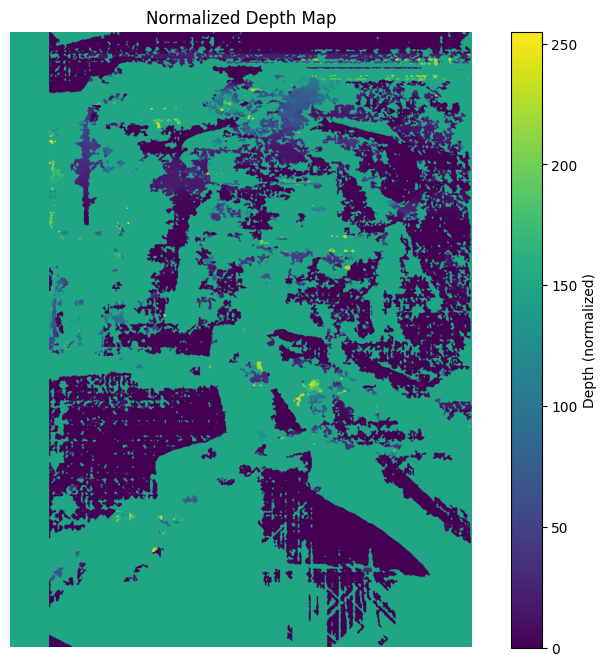


Creating interactive 3D point cloud with Open3D (Total points: 255082)...
3D point cloud saved to '3d_reconstruction\point_cloud.ply'.

Interactive 3D visualization displayed. Close the window to continue.

Step 4: Depth Map Generation & 3D Visualization complete.


In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import open3d as o3d # For interactive 3D visualization

# ===================================================================
# -------------------- CONFIGURATION (EDIT THIS) --------------------
# ===================================================================

# Path to your saved calibration file from Step 1
CALIBRATION_FILE = 'stereo_calibration.npz'

# Input directory for disparity map from Step 3 (if running standalone)
DISPARITY_MAP_DIR = 'disparity_maps' 
# If running this cell directly after Step 3, 'raw_disparity' should be in memory.
# If running as a standalone script or new notebook session, you'll need to load it.
# For simplicity, we'll assume it's in memory or you save/load it as part of raw_disparity.npz
# You might need to save raw_disparity from previous cell if you restart kernel
# np.savez(os.path.join(DISPARITY_MAP_DIR, 'raw_disparity.npz'), raw_disparity=raw_disparity)

# Path to the LEFT rectified image (for coloring the 3D point cloud)
RECTIFIED_IMAGES_DIR = 'rectified_images'
LEFT_RECTIFIED_IMAGE_PATH = os.path.join(RECTIFIED_IMAGES_DIR, 'left_rectified.jpg')

# Output directory for depth map and 3D point cloud (will be created if it doesn't exist)
OUTPUT_DIR_3D = '3d_reconstruction'

# Disparity threshold for invalid points (same as used in disparity_visual)
# Points with disparity <= this value will be considered invalid for 3D reconstruction
# This should correspond to the minDisparity value used in SGBM.
MIN_VALID_DISPARITY_THRESHOLD = 0.0 # From SGBM_MIN_DISPARITY

# ===================================================================
# -------------------- END OF CONFIGURATION -------------------------
# ===================================================================

print("--- Step 4: Depth Map Generation & 3D Visualization ---")

# --- Load raw_disparity if not in memory (only if running this cell standalone) ---
# If you just ran Step 3 in the same session, 'raw_disparity' should be available.
# If not, you'd need to load it. For this code, we assume it's available or
# you've modified Step 3 to save it. For this example, let's assume raw_disparity is
# directly passed from the previous cell or loaded from a saved npz file.
# If you are getting a 'NameError: name 'raw_disparity' is not defined', 
# then you need to run Step 3 first OR save and load it.
# Example of loading:
# with np.load(os.path.join(DISPARITY_MAP_DIR, 'raw_disparity.npz')) as data:
#     raw_disparity = data['raw_disparity']
# print("Raw disparity map loaded.")


# --- Load Q matrix and image_size from calibration file ---
try:
    with np.load(CALIBRATION_FILE) as data:
        Q = data['Q']
        image_size = tuple(data['imageSize'])
    print(f"Q matrix and image size loaded from {CALIBRATION_FILE}")
except FileNotFoundError:
    print(f"Error: Calibration file '{CALIBRATION_FILE}' not found. Please ensure it exists.")
    exit()
except Exception as e:
    print(f"Error loading calibration data (Q matrix): {e}")
    exit()

# --- Load the Left Rectified Image (for coloring the point cloud) ---
try:
    img_left_rectified_color = cv2.imread(LEFT_RECTIFIED_IMAGE_PATH)
    if img_left_rectified_color is None:
        raise FileNotFoundError(f"Could not load left rectified image: {LEFT_RECTIFIED_IMAGE_PATH}")
    print(f"Left rectified image loaded from {LEFT_RECTIFIED_IMAGE_PATH}")
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please ensure LEFT_RECTIFIED_IMAGE_PATH points to a valid image from Step 2.")
    exit()

# --- 1. Reproject to 3D ---
print("\nReprojecting disparity map to 3D point cloud (this might take a moment)...")
points_3d = cv2.reprojectImageTo3D(raw_disparity, Q, handleMissingValues=True)

# --- 2. Generate Dense Depth Map (for visualization) ---
# Depth is typically the Z-coordinate. We will normalize it for a grayscale image.
# We also need to filter out invalid points (disparity <= MIN_VALID_DISPARITY_THRESHOLD or very large Z)
valid_mask = (raw_disparity > MIN_VALID_DISPARITY_THRESHOLD) # Mask based on original disparity values

# Create an empty depth map
depth_map = np.zeros(raw_disparity.shape, dtype=np.float32)

# Only consider Z values for valid points
valid_z_values = points_3d[:, :, 2][valid_mask]

if valid_z_values.size > 0:
    # Filter out extremely large Z values which can be invalid (infinity)
    # Adjust max_depth_limit based on your scene, e.g., 10000mm = 10m
    max_depth_limit = 10000 # Example: 10 meters, adjust based on your scene's range

    # Further filter out points that are too far or too close, or NaN
    final_valid_mask = valid_mask & \
                       (points_3d[:, :, 2] < max_depth_limit) & \
                       (points_3d[:, :, 2] > 0.1) # Ensure Z is positive and not near 0

    # Fill the depth map with valid Z values
    depth_map[final_valid_mask] = points_3d[:, :, 2][final_valid_mask]

    # Normalize depth map for visualization (0-255 grayscale)
    # Ignore invalid (zero) depths for normalization calculation
    depth_values_for_norm = depth_map[depth_map > 0] 

    if depth_values_for_norm.size > 0:
        min_depth = depth_values_for_norm.min()
        max_depth = depth_values_for_norm.max()
        
        # Avoid division by zero if all valid depths are the same
        if max_depth > min_depth:
            normalized_depth_map = 255 * (depth_map - min_depth) / (max_depth - min_depth)
        else: # If all valid depths are the same, set to mid-gray for visualization
            normalized_depth_map = (depth_map > 0) * 127 # Set valid points to mid-gray
    else:
        normalized_depth_map = np.zeros_like(depth_map, dtype=np.uint8) # No valid depth to show
        print("Warning: No valid depth values after filtering for normalization.")
else:
    normalized_depth_map = np.zeros_like(depth_map, dtype=np.uint8)
    print("Warning: No valid Z values found for depth map generation.")

normalized_depth_map_8bit = normalized_depth_map.astype(np.uint8)

# Save the visualized depth map
os.makedirs(OUTPUT_DIR_3D, exist_ok=True)
cv2.imwrite(os.path.join(OUTPUT_DIR_3D, 'depth_map_visual.jpg'), normalized_depth_map_8bit)
print(f"Visualized depth map saved to '{OUTPUT_DIR_3D}'.")

# Display depth map
plt.figure(figsize=(10, 8))
plt.imshow(normalized_depth_map_8bit, cmap='viridis') # 'viridis', 'jet', 'gray_r' are good colormaps
plt.colorbar(label='Depth (normalized)')
plt.title('Normalized Depth Map')
plt.axis('off')
plt.show()

# --- 3. Prepare Point Cloud for Open3D ---
# Filter out invalid 3D points (where Z is NaN or very large/small)
# A common threshold for Z is > 0 and < some reasonable maximum (e.g., 10000mm)
# The `raw_disparity` value of 0 often indicates no match, leading to invalid 3D points.
valid_points_mask = (raw_disparity > MIN_VALID_DISPARITY_THRESHOLD) & \
                    (points_3d[:, :, 2] < 10000) & (points_3d[:, :, 2] > 0.1) # Filter Z for realism

valid_points_3d = points_3d[valid_points_mask]
valid_colors = img_left_rectified_color[valid_points_mask]

# Convert colors from BGR to RGB and normalize to [0, 1] for Open3D
valid_colors_rgb_normalized = valid_colors[:, ::-1] / 255.0 

# --- 4. Visualize 3D Point Cloud with Open3D ---
if valid_points_3d.shape[0] > 0:
    print(f"\nCreating interactive 3D point cloud with Open3D (Total points: {valid_points_3d.shape[0]})...")
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(valid_points_3d)
    pcd.colors = o3d.utility.Vector3dVector(valid_colors_rgb_normalized)

    # Optional: Estimate normals for better rendering
    pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
    
    # Save the point cloud to a PLY file (can be opened by many 3D viewers)
    ply_output_path = os.path.join(OUTPUT_DIR_3D, 'point_cloud.ply')
    o3d.io.write_point_cloud(ply_output_path, pcd)
    print(f"3D point cloud saved to '{ply_output_path}'.")

    o3d.visualization.draw_geometries([pcd], 
                                     window_name='3D Point Cloud Reconstruction',
                                     width=800, height=600,
                                     left=50, top=50,
                                     zoom=0.7,
                                     front=[0, 0, -1], # Camera orientation
                                     lookat=[0, 0, 1], # Point camera looks at
                                     up=[0, -1, 0]) # Up direction
    
    print("\nInteractive 3D visualization displayed. Close the window to continue.")
else:
    print("Warning: No valid 3D points found after filtering. 3D visualization skipped.")
    print("Check disparity map quality and filtering thresholds.")

print("\nStep 4: Depth Map Generation & 3D Visualization complete.")